In [1]:
import torch
from matplotlib import pyplot as plt
from trajectories import TrajectoriesDataset, load_trajectories
from torch.utils.data import DataLoader


In [2]:
def load_dataset(path):
    dataset = load_trajectories(path)

    print('Episodes:', len(dataset))
    print('Observation shape (episode):', dataset[0][0].shape, dataset[0][0].dtype)
    print('Action shape (episode):', dataset[0][1].shape, dataset[0][1].dtype)
    print('Reward shape (episode):', dataset[0][2].shape, dataset[0][2].dtype)

    return dataset

def normalize_obs(dataset):
    dataset.observations = dataset.observations.type(torch.FloatTensor)

    print('before:')
    print('unique:', torch.unique(dataset.observations))
    print('mean:', torch.mean(dataset.observations, axis=(0,1,2,3)))
    print('min:', torch.min(dataset.observations))
    print('max:', torch.max(dataset.observations))
    print('std:', torch.std(dataset.observations, axis=(0,1,2,3)))

    # normalize observations
    mean = torch.mean(dataset.observations, axis=(0, 1, 2, 3))
    std = torch.std(dataset.observations, axis=(0, 1, 2, 3))
    dataset.observations -= mean
    dataset.observations /= std

    print('after:')
    print('unique:', torch.unique(dataset.observations))
    print('mean:', torch.mean(dataset.observations, axis=(0,1,2,3)))
    print('min:', torch.min(dataset.observations))
    print('max:', torch.max(dataset.observations))
    print('std:', torch.std(dataset.observations, axis=(0,1,2,3)))
    return mean, std

In [3]:
dataset_new = load_dataset('trajectories/ep30000_dur23.18_ret0.90/trajectories/0.10K.pt')


Episodes: 100
Observation shape (episode): torch.Size([50, 24, 24, 3]) torch.float32
Action shape (episode): torch.Size([50, 3]) torch.float32
Reward shape (episode): torch.Size([50]) torch.int64


In [4]:
# print('Old:\n')
# normalize_obs(dataset_old)

print('\nNew:\n')
mean, std = normalize_obs(dataset_new)



New:

before:
unique: tensor([  0.,  56.,  76., 113., 141., 146., 226., 249., 255.])
mean: tensor([22.3605, 16.0239, 16.7821])
min: tensor(0.)
max: tensor(255.)
std: tensor([63.2135, 46.2792, 51.9221])
after:
unique: tensor([-0.3537, -0.3462, -0.3232,  0.5322,  0.8638,  1.1405,  1.2960,  1.4339,
         1.8768,  1.9559,  2.0955,  2.4887,  2.7005,  2.8085,  3.2215,  3.6802,
         4.4724,  4.5372,  5.1638])
mean: tensor([ 9.8674e-08, -2.4414e-08,  6.9173e-08])
min: tensor(-0.3537)
max: tensor(5.1638)
std: tensor([1.0000, 1.0000, 1.0000])


In [6]:

from reward_predictor import RewardPredictor
from train_reward_predictor import PAD_VAL, ACTION_SPACE_SIZE, OBSERVATION_SPACE_DIMS

loader = DataLoader(dataset_new, batch_size=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RewardPredictor(OBSERVATION_SPACE_DIMS, ACTION_SPACE_SIZE, device, verbose=False).to(device)

for i, batch in enumerate(loader):
    observations, actions, rewards = batch

    observations = observations.transpose(
                    2, 4).transpose(0, 1).to(device)
    actions = actions.transpose(0, 1).to(device)
    rewards = rewards.transpose(0, 1).to(device)

    returns = torch.zeros_like(rewards)
    returns += torch.sum(rewards, axis=0)[None, :]
    returns += 1  # turns values (-1,0,1) into "classes" (0,1,2)

    output = model(observations, actions)
    
    print(output)

    break


tensor([[[ 4.3062e-01,  1.0083e-01, -6.8714e-01],
         [ 7.7522e-01,  3.5180e-01, -6.4198e-01],
         [ 4.4142e-01,  5.0073e-01, -8.8944e-01],
         ...,
         [-2.5461e-01,  6.4589e-01, -1.5893e-01],
         [-1.3976e-01,  6.0488e-01, -3.8808e-01],
         [-8.3813e-02,  8.9790e-01, -5.4784e-01]],

        [[ 8.5033e-01,  1.3989e-01, -9.3100e-01],
         [ 3.0062e-01,  3.1398e-01, -8.8432e-01],
         [ 5.9538e-01,  8.1007e-01, -6.7732e-01],
         ...,
         [-4.6907e-01,  8.8281e-01, -3.4719e-01],
         [-2.9305e-02,  7.9438e-01, -4.2120e-01],
         [ 9.1359e-02,  2.6912e-01, -6.9569e-01]],

        [[ 1.2330e+00, -4.1983e-02, -8.5179e-01],
         [ 6.3436e-01,  2.6201e-01, -1.0113e+00],
         [ 1.2842e+00,  4.4531e-01, -6.8709e-01],
         ...,
         [-1.6005e-01,  5.6185e-01, -5.6794e-01],
         [-6.8158e-02,  5.9157e-01, -6.3827e-01],
         [-2.2211e-01,  9.0596e-01, -9.4694e-01]],

        ...,

        [[ 3.5871e-01, -1.8932e-01, -4

unique: tensor([1, 2])
red tensor([255,  76,  76], dtype=torch.uint8)
pink tensor([255,  76, 249], dtype=torch.uint8)


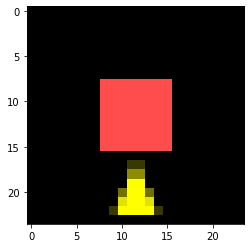

In [51]:
# debug
loader = DataLoader(dataset_new, batch_size=128)
episode = 3

for i, batch in enumerate(loader):
    observations, actions, reward = batch

    # observations = observations.type(torch.FloatTensor)
    # observations[observations == 10] = 0

    # mean = torch.mean(observations, axis=(0,1,2,3))
    # std = torch.std(observations, axis=(0,1,2,3))
    # observations = (observations - mean) / std

    returns = torch.ones_like(reward) * 0
    sums = torch.sum(reward, axis=1)

    returns += sums[:, None]
    returns += 1
    print('unique:', torch.unique(returns))
    renormalized = (observations * std + mean).type(torch.ByteTensor)
    plt.imshow(renormalized[episode, 3, :, :, :])
    print('red',renormalized[episode, 3, 12, 12, :])
    print('pink',renormalized[episode, 7, 12, 12, :])
    plt.show()
    break